# Model Factory

In [6]:
import os, sys, math, datetime, csv
import psutil

# import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL

import PIL.Image


In [7]:

import tensorflow as tf
import tensorflow_datasets as tfds

# see https://github.com/microsoft/pylance-release/issues/1066
#from tensorflow import keras
keras = tf.keras
from keras.layers import (
    Input,
    Dense,
    Add,
    Flatten,
    Conv2D,
    Dropout,
    Reshape,
    Activation,
    DepthwiseConv2D,
    MaxPooling2D,
    AvgPool2D,
    AveragePooling2D,
    GlobalAveragePooling2D,
    Softmax,
    BatchNormalization,
    Concatenate,
    Permute,
    ReLU
)

from keras.models import Model
from keras.regularizers import l2
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#from dotenv import load_dotenv
#from tf2cv.model_provider import get_model as tf2cv_get_model

# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths, get_file_size, create_model_name, append_dict_to_csv
from workbench.tensorflow import set_batchnorm_momentum

import wandb
from wandb.keras import WandbCallback

# import deeplake

In [8]:
seed_1 = 1
seed_2 = 15
seed_3 = 30
seed_4 = 42
seed_5 = 75

seed = seed_1

# set the random seeds#
#os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed) # setting tensorflow global seed
tf.keras.utils.set_random_seed(seed)
#tf.config.experimental.enable_op_determinism()

In [9]:
models_dir = initialize()

In [10]:
tf.keras.backend.clear_session()

# Define the model

In [11]:
automated = False


img_res = 96
channels = 3
classes = 2
alpha = 0.35
global dropout_rate
dropout_rate = 0.001 # 0.2
architecture = "mobilenet_v1" # "mobilenet_v3_small_keras" ##"shufflenet_v2tiny" # ##"mobilenet_v3_large_keras"  #"efficientNetB0_keras" #"mobilenet_v2_keras" #
loop_depth = 5
groups = 1 # [1, 2, 3, 4, 8] used in shuffleNetv1
first_layer_channels = 4 # standard 24
last_layer_channels = 1024 # standard 1024


In [12]:
input_shape = (img_res,img_res,channels)

In [13]:
model_stats = {"img_res" : img_res,
    "classes" : classes,
    "channels" : channels,
    "alpha" : alpha,
    "dropout_rate" : dropout_rate,
    }

# Helper functions

In [14]:
def set_batchnorm_momentum(model, momentum=0.9):
    for layer in model.layers:
        if type(layer)==type(tf.keras.layers.BatchNormalization()):
            #print(layer.momentum)
            layer.momentum=momentum
    return model

# MobileNet V1 & V2

Fast downsampling mobilenet https://github.com/qinzheng93/FD-MobileNet/blob/master/pyvision/models/ImageNet/MobileNet.py  

Keras Effnet https://github.com/arthurdouillard/keras-effnet/blob/master/effnet.py  



In [15]:
def mobilenet_v1(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V1 specification, using the functional API.
    The function returns the model.
    """
    global dropout_rate
    
    # MobileNet V1 Block
    def mobilenet_v1_block(x, filters, strides):
        # Depthwise convolution
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same")(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        # Pointwise convolution = standard convolution with kernel size =1
        x = Conv2D(filters=filters, kernel_size=1, strides=1)(x)  # strides for pointwise convolution must be 1
        x = BatchNormalization()(x)
        x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

        return x

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=3, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)  # TODO: option to change to ReLu6 or HardSwish

    # Main part of the model
    x = mobilenet_v1_block(x, filters=64 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=128 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=256 * alpha, strides=1)
    x = mobilenet_v1_block(x, filters=512 * alpha, strides=2)

    for _ in range(loop_depth):  # TODO: reduce the depth of the net for faster inference
        x = mobilenet_v1_block(x, filters=512 * alpha, strides=1)

    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=2)
    x = mobilenet_v1_block(x, filters=1024 * alpha, strides=1)

    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x) #
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)

    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=x.shape[-1], strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1")

    return model

In [16]:
'''
MobilnetV1 from Silican Labs github page:
https://github.com/SiliconLabs/platform_ml_models/blob/master/eembc/Person_detection/mobilenet_v1_eembc.py
'''

def mobilenet_v1_vvw(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    # Mobilenet parameters
    #input_shape = [96,96,3] # resized to 96x96 per EEMBC requirement
    #num_classes = 2 # person and non-person
    num_filters = 8 # normally 32, but running with alpha=.25 per EEMBC requirement

    inputs = Input(shape=input_shape)
    x = inputs # Keras model uses ZeroPadding2D()

    # 1st layer, pure conv
    # Keras 2.2 model has padding='valid' and disables bias
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) # Keras uses ReLU6 instead of pure ReLU

    # 2nd layer, depthwise separable conv
    # Filter size is always doubled before the pointwise conv
    # Keras uses ZeroPadding2D() and padding='valid'
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 3rd layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 4th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 5th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 6th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 7th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 8th-12th layers, identical depthwise separable convs
    # 8th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 9th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 10th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 11th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 12th
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 13th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    num_filters = 2*num_filters
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 14th layer, depthwise separable conv
    x = DepthwiseConv2D(kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Average pooling, max polling may be used also
    # Keras employs GlobalAveragePooling2D 
    x = AveragePooling2D(pool_size=x.shape[1:3])(x)
    #x = MaxPooling2D(pool_size=x.shape[1:3])(x)

    # Keras inserts Dropout() and a pointwise Conv2D() here
    # We are staying with the paper base structure

    # Flatten, FC layer and classify
    x = Flatten()(x)
    outputs = Dense(classes, activation='softmax')(x)

    # Instantiate model.
   
    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv1vvw")
    return model


In [17]:
##### MOBILENET V2 not yet correctly implemented!


# Formular to avoid exccessive downsampling
# copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v



def mobilenet_v2(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
    The function returns the model.
    """

    global block_id
    block_id = 1
    global dropout_rate

    # Expansion block
    def expansion_block(x, t, filters, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
        x = BatchNormalization(name = prefix + "expand_bn")(x)
        x = ReLU(6, name=prefix + "expand_relu")(x)
        return x

    def depthwise_block(x, strides, block_id):
        prefix = f"block_{block_id}_"
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
        x = BatchNormalization(name = prefix + "dw_bn")(x)
        x = ReLU(6, name=prefix + "dw_relu")(x)
        return x

    def projection_block(x, out_channels, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
        x = BatchNormalization(name = prefix + "compress_bn")(x)
        return x

    def bottleneck_residual_block(x, t, filters, out_channels, strides):
        global block_id
        block_id =  block_id +1
        y = expansion_block(x, t, filters, block_id)
        y = depthwise_block(y, strides, block_id)
        y = projection_block(y, out_channels, block_id)

        # TODO: Check if this implementation is ok
        if y.shape[-1] == x.shape[-1]:
            y = Add()([x, y])
        return y

    # Avoid massive downsampling
    first_block_filters = _make_divisible(32 * alpha, 8)

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


    # Main part of the model
    block_id = 0
    x = depthwise_block(x, strides=1, block_id=block_id)
    x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

    # 2 identical layers
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

    # 4 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we increase the number of output
    # channels.
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    # 1*1 conv
    x = Conv2D(filters=last_block_filters, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        #outputs = Activation("softmax")(x)
        outputs = Softmax()(x)


    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetv2")

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)

    return model

In [18]:
### MY VERSION OF MOBILENET V2

# Formular to avoid exccessive downsampling
# copied from: https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L563

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v



def mobilenet_vme(input_shape, classes, alpha=1, loop_depth=5, global_average_pooling=True):
    """
    This function builds a CNN model according to the MobileNet V2 specification, using the functional API.
    The function returns the model.
    """

    global block_id
    block_id = 1
    global dropout_rate

    # Expansion block
    def expansion_block(x, t, filters, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(kernel_size=1, filters = filters * t, use_bias=False, name= prefix + "expand")(x)
        x = BatchNormalization(name = prefix + "expand_bn")(x)
        x = ReLU(6, name=prefix + "expand_relu")(x)
        return x

    def depthwise_block(x, strides, block_id):
        prefix = f"block_{block_id}_"
        x = DepthwiseConv2D(kernel_size=3, strides=strides, padding="same", use_bias=False, name= prefix + "dw_conv")(x)
        x = BatchNormalization(name = prefix + "dw_bn")(x)
        x = ReLU(6, name=prefix + "dw_relu")(x)
        return x

    def projection_block(x, out_channels, block_id):
        prefix = f"block_{block_id}_"
        x = Conv2D(filters=out_channels, kernel_size=1, strides=1, padding="same", use_bias=False, name= prefix + "compress")(x)
        x = BatchNormalization(name = prefix + "compress_bn")(x)
        return x

    def bottleneck_residual_block(x, t, filters, out_channels, strides):
        global block_id
        block_id =  block_id +1
        y = expansion_block(x, t, filters, block_id)
        y = depthwise_block(y, strides, block_id)
        y = projection_block(y, out_channels, block_id)

        # TODO: Check if this implementation is ok
        if y.shape[-1] == x.shape[-1]:
            y = Add()([x, y])
        return y

    # Avoid massive downsampling
    first_block_filters = _make_divisible(32 * alpha, 8)

    # Stem of the model
    inputs = Input(shape=input_shape)
    x = Conv2D(filters=first_block_filters, kernel_size=3, strides=2, padding="same", use_bias=False)(inputs)
    x = BatchNormalization(name='conv1_bn')(x)
    x = ReLU(6, name = 'conv1_relu')(x)  # TODO: option to change to ReLu6 or HardSwish


    # Main part of the model
    block_id = 0
    x = depthwise_block(x, strides=1, block_id=block_id)
    x = projection_block(x, out_channels=16 * alpha, block_id=block_id)

    # 2 identical layers
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=2) #, block_id=block_id +1)
    x  = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=24 * alpha, strides=1) #, block_id=block_id +1)

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=32 * alpha, strides=1) #, block_id=block_id +1)   

    # 4 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=64 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=96 * alpha, strides=1) #, block_id=block_id +1)   

    # 3 repeated bottle_necks
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=2) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   
    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=160 * alpha, strides=1) #, block_id=block_id +1)   

    x = bottleneck_residual_block(x, t=6, filters=x.shape[-1], out_channels=320 * alpha, strides=1) #, block_id=block_id +1) 


    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we increase the number of output
    # channels.
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    # 1*1 conv
    x = Conv2D(filters=last_block_filters, kernel_size=1, padding="same", use_bias=False, name="last_conv")(x)
    x = BatchNormalization(name='last_bn')(x)
    x = ReLU(6,name='last_relu')(x)


    if global_average_pooling:  
        x = GlobalAveragePooling2D(keepdims=True)(x)
        x = Dropout(dropout_rate)(x)
        x = Conv2D(filters=classes, kernel_size=1, strides=1, padding="same")(x)
        x = Reshape(target_shape=(classes,))(x)
        outputs = Activation("softmax")(x)
        #outputs = Softmax()(x)


    else:
        # use the original implementation from the paper with average pooling and fully-connected layers
        x = AvgPool2D(pool_size=7, strides=1)(x)  # TODO: pool_size is dependent on the input resolution, lower resolutions than 224 might crash the architecture
        outputs = Dense(units=classes, activation="softmax")(x)  # TODO: is there a stride=1 implementation in Dense?

    model = Model(inputs=inputs, outputs=outputs, name="mobilenetvme")

    return model

In [19]:
# # form https://github.com/keras-team/keras/blob/v2.11.0/keras/applications/mobilenet_v2.py#L96-L485
# def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
#     """Inverted ResNet block."""
#     channel_axis = 1 if backend.image_data_format() == "channels_first" else -1

#     in_channels = backend.int_shape(inputs)[channel_axis]
#     pointwise_conv_filters = int(filters * alpha)
#     # Ensure the number of filters on the last 1x1 convolution is divisible by
#     # 8.
#     pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
#     x = inputs
#     prefix = f"block_{block_id}_"

#     if block_id:
#         # Expand with a pointwise 1x1 convolution.
#         x = layers.Conv2D(
#             expansion * in_channels,
#             kernel_size=1,
#             padding="same",
#             use_bias=False,
#             activation=None,
#             name=prefix + "expand",
#         )(x)
#         x = layers.BatchNormalization(
#             axis=channel_axis,
#             epsilon=1e-3,
#             momentum=0.999,
#             name=prefix + "expand_BN",
#         )(x)
#         x = layers.ReLU(6.0, name=prefix + "expand_relu")(x)
#     else:
#         prefix = "expanded_conv_"

#     # Depthwise 3x3 convolution.
#     if stride == 2:
#         x = layers.ZeroPadding2D(
#             padding=imagenet_utils.correct_pad(x, 3), name=prefix + "pad"
#         )(x)
#     x = layers.DepthwiseConv2D(
#         kernel_size=3,
#         strides=stride,
#         activation=None,
#         use_bias=False,
#         padding="same" if stride == 1 else "valid",
#         name=prefix + "depthwise",
#     )(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis,
#         epsilon=1e-3,
#         momentum=0.999,
#         name=prefix + "depthwise_BN",
#     )(x)

#     x = layers.ReLU(6.0, name=prefix + "depthwise_relu")(x)

#     # Project with a pointwise 1x1 convolution.
#     x = layers.Conv2D(
#         pointwise_filters,
#         kernel_size=1,
#         padding="same",
#         use_bias=False,
#         activation=None,
#         name=prefix + "project",
#     )(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis,
#         epsilon=1e-3,
#         momentum=0.999,
#         name=prefix + "project_BN",
#     )(x)

#     if in_channels == pointwise_filters and stride == 1:
#         return layers.Add(name=prefix + "add")([inputs, x])
#     return 

In [20]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=dropout_rate,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


In [21]:
def mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=input_shape,
        alpha=alpha,
        include_top=True, # False should be corect
        weights=None, #'imagenet'
        input_tensor=None,
        pooling="avg",
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model


# MobileNet V3

In [22]:
def mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Small(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )
    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


In [23]:
def mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha):
    global dropout_rate
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=input_shape,
        minimalistic=False, # TODO find out about this parameter
        alpha=alpha,
        include_top=True,
        weights=None,
        input_tensor=None,
        classes=classes,
        classifier_activation="softmax",
        dropout_rate=dropout_rate,
        include_preprocessing=False
        #**kwargs
        )

    # https://github.com/tensorflow/tensorflow/issues/36065
    # model in the original version does not train because momentum is set to 0.999 by default
    model = set_batchnorm_momentum(model, momentum=0.9)
    
    return model


# EfficientNet

In [24]:
def efficientNetB0_keras(input_shape, classes= classes, alpha= alpha):
    model = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=True,
        weights= None, #'imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    return model

# ShuffleNets

In [25]:
def shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups = 1):
    # inspired by https://github.com/Haikoitoh/paper-implementation/blob/main/ShuffleNet.ipynb

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={
        "1" : 144,
        "2" : 200,
        "3" : 240,
        "4" : 272,
        "8" : 384
    }

    start_channels = start_channels_dict[str(groups)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def shuffle_unit(x, groups, channels, strides):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = channel_shuffle(x, groups)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
        x = BatchNormalization()(x)

        if strides == (2,2):
            channels = channels - y.shape[-1]
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
        x = BatchNormalization()(x)

        if strides ==(1,1):
            x =Add()([x,y])
        if strides == (2,2):
            y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
            x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        
        x = ReLU()(x)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels * alpha ,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels * alpha ,strides=(1,1))

    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv1")
    return model

In [26]:
def shufflenet_v2(input_shape, classes=classes, alpha=alpha, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.5" : 48,
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    first_layer_channels = 24
    last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    def basic_unit(x, channels):

        y,z = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 
        # batch, width, height, channels = x.get_shape().as_list()
        # channel_split = channels//2
        # y = x[:, :, :, 0:channel_split+1]
        # print(y.shape)
        # z = x[:, :, :, channel_split:-1]
        # print(z.shape)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        
        y = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        y = Concatenate(axis=-1)([y,z]) # TODO: check if the axis is correct!
        y = channel_shuffle(y, 2)
        return y

    def down_sampling_unit(x, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    for i,repetition in enumerate(repetitions):

        x  = down_sampling_unit(x, channels)

        for j in range(repetition):
            x = basic_unit(x, channels)

        channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2")
    return model

In [27]:
def shufflenet_v2tiny(input_shape, classes=classes, alpha=alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False):
    

    #groups = 2 # [1, 2, 3, 4, 8]

    start_channels_dict={  # based on alpha factor
        "0.05" : 6,
        "0.1" : 12,
        "0.2" : 24,
        "0.25" : 28,
        "0.3" : 34,        
        "0.5" : 48, # this is the smallest original architecture alpha
        "1" : 116,
        "1.5" : 176,
        "2" : 244,
    }

    # first_layer_channels = 24
    # last_layer_channels = 1024

    start_channels = start_channels_dict[str(alpha)]

    def channel_shuffle(x, groups):  
        batch, width, height, channels = x.get_shape().as_list()
        group_ch = channels // groups

        x = Reshape([width, height, group_ch, groups])(x)
        x = Permute([1, 2, 4, 3])(x)
        x = Reshape([width, height, channels])(x)
        return x

    #     x = Reshape([width, height, group_ch, groups])(x)
    #     x = Permute([1, 2, 4, 3])(x)
    #     x = Reshape([width, height, channels])(x)
    #     return x

    # https://stackoverflow.com/questions/62794840/apply-channel-shuffle-in-tensorflow-or-keras

    # trouble version
    # def channel_shuffle(x, groups):
    #     # g = 2
    #     b, h, w, c = x.shape.as_list()
    #     x = tf.reshape(x,[-1, h, w, groups, c // groups])
    #     x = tf.transpose(x, perm = [0, 1, 2, 4, 3])
    #     #x = tf.reverse(x,[-1]) 
    #     x = tf.reshape(x, [-1, h, w, c])
    #     return x


    # https://github.com/MG2033/ShuffleNet/blob/master/layers.py#L238
    # def channel_shuffle(name, x, num_groups):
    #     with tf.variable_scope(name) as scope:
    #         n, h, w, c = x.shape.as_list()
    #         x_reshaped = tf.reshape(x, [-1, h, w, num_groups, c // num_groups])
    #         x_transposed = tf.transpose(x_reshaped, [0, 1, 2, 4, 3])
    #         output = tf.reshape(x_transposed, [-1, h, w, c])
    #         return output


    ## https://github.com/timctho/shufflenet-v2-tensorflow/blob/master/module.py
    def channel_shuffle(x, groups):
    #with tf.variable_scope('shuffle_unit'):
    
        n, h, w, c = x.get_shape().as_list()
        x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, groups, c // groups]))
        x = tf.transpose(x, tf.convert_to_tensor([0, 1, 2, 4, 3]))
        x = tf.reshape(x, shape=tf.convert_to_tensor([tf.shape(x)[0], h, w, c]))
        return x

    def basic_unit(x, channels):

        #x,y = tf.split(x, num_or_size_splits=2, axis=-1) # channel split 

        batch, width, height, channels = x.get_shape().as_list()
        channel_split = channels//2 
        y = x[:, :, :, 0:channel_split]
        print(f"Basic unit y: {y.shape} - channels: {channels}")
        z = x[:, :, :, channel_split-1:-1]
        print(f"Basic unit z: {z.shape} - channels: {channels}")



        y = Conv2D(channels, kernel_size = 1, strides = (1,1) ,padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        
        y = DepthwiseConv2D(kernel_size = (3,3), strides = (1,1), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        y = Concatenate(axis=-1)([y,z]) # TODO: check if the axis is correct!
        y = channel_shuffle(y, 2) # use 2 groups
        return y

    def down_sampling_unit(x, channels):

        y = x
        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        x = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)

        x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        y = DepthwiseConv2D(kernel_size = (3,3), strides = (2,2), padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)

        y = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', use_bias=use_bias)(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        x = Concatenate(axis=-1)([x,y]) # TODO: check if the axis is correct!
        x = channel_shuffle(x, 2)
        return x

    # Main architecture

    input = Input (input_shape)

    x =  Conv2D (first_layer_channels ,kernel_size=3, strides = (2,2), padding = 'valid', use_bias=use_bias)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)
    
    # exclude pooling layer to avoid model collapse
    x = MaxPooling2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    channels = start_channels

    # stage 2
    print("stage 2")
    x = down_sampling_unit(x, channels)
    for i in range(repetitions[0]):
        print(f"rep {i}, channels {channels}")
        x = basic_unit(x, channels)
    
    # stage 3
    print("stage 3")
    channels = channels *2
    print("channels")

    x = down_sampling_unit(x, channels)
    for i in range(repetitions[1]):
        print(f"rep {i}, channels {channels}")
        x = basic_unit(x, channels)

    # stage 3
    channels = channels *2

    x = down_sampling_unit(x, channels)
    for i in range(repetitions[2]):
        x = basic_unit(x, channels)
       

    # for i,repetition in enumerate(repetitions):

    #     x  = down_sampling_unit(x, channels)

    #     for j in range(repetition):
    #         x = basic_unit(x, channels)

    #     channels = channels * 2 # ShuffleNet V1 *(2**1)

    x =  Conv2D (last_layer_channels, kernel_size=1,strides = (1,1), padding = 'same', use_bias=use_bias)(x)
    x = GlobalAveragePooling2D()(x)

    output = Dense(classes,activation='softmax')(x)

    model = Model(input, output, name="shufflenetv2tiny")
    return model

# Getting model architecture

In [28]:
#model = net = tf2cv_get_model("resnet18", pretrained=True, data_format="channels_last")
#model.build(input_shape)
#model.name

In [29]:

# model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
# model.name

In [30]:
#model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
#model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)

In [31]:
def get_model(architecture, input_shape, classes, alpha, loop_depth= None,first_layer_channels=None, last_layer_channels=None, use_bias=False):
    global base_model_name
    if architecture=="mobilenet_v1":
        if loop_depth==None:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v1(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name

    elif architecture=="mobilenet_v1_vvw":
        model = mobilenet_v1_vvw(input_shape, classes=classes, alpha=alpha)
        variation_code ="vvw"
        base_model_name = model.name

    elif architecture=="mobilenet_v1_keras":
        model = mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]+"v1"

    elif architecture=="mobilenet_v2":
        if loop_depth==None:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_v2(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name

    # my personal mobilenet version    
    elif architecture=="mobilenet_vme":
        if loop_depth==None:
            model = mobilenet_vme(input_shape, classes=classes, alpha=alpha)
            variation_code ="000"
        else:
            model = mobilenet_vme(input_shape, classes=classes, alpha=alpha, loop_depth=loop_depth)
            variation_code ="l"+str(loop_depth)
        base_model_name = model.name
    elif architecture=="mobilenet_v2_keras":
        model = mobilenet_v2_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]#+"v2"
    elif architecture== "mobilenet_v3_small_keras":
        model = mobilenet_v3_small_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture== "mobilenet_v3_large_keras":
        model = mobilenet_v3_large_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = model.name.split("_")[0]
    elif architecture=="efficientNetB0_keras":
        model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)
        variation_code ="keras"
        base_model_name = "efficientNetB0"
    elif architecture=="shufflenet_v1":
        model = shufflenet_v1(input_shape, classes=classes, alpha= alpha, groups=groups)
        variation_code ="g"+str(groups)
        base_model_name = model.name
    elif architecture=="shufflenet_v2":
        model = shufflenet_v2(input_shape, classes=classes, alpha= alpha)
        variation_code ="000"
        base_model_name = model.name

    elif architecture=="shufflenet_v2tiny":
        if (first_layer_channels==None) |(last_layer_channels==None) :
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=24, last_layer_channels=1024, use_bias=False) 
            variation_code ="000"
        else:
            model = shufflenet_v2tiny(input_shape, classes, alpha, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels, use_bias=False) 
            variation_code = "f"+str(first_layer_channels)+"l"+str(last_layer_channels)
        base_model_name = model.name
    else:
        #raise Exception e:
        print(f"Model architecture {architecture} is not supported.")

    return model, variation_code


In [32]:
model, variation_code = get_model(architecture, input_shape, classes, alpha, loop_depth, first_layer_channels=first_layer_channels, last_layer_channels=last_layer_channels)
base_model_name

'mobilenetv1'

In [33]:
#model.build(input_shape)

In [34]:
#model = set_batchnorm_momentum(model)

In [35]:
# for layer in model.layers:
#     if type(layer)==type(tf.keras.layers.BatchNormalization()):
#         print(layer.momentum)
#         print(layer.trainable)
#         #layer.momentum=0.9

In [36]:
variation_code

'l5'

In [37]:
# model = tf.keras.applications.efficientnet.EfficientNetB0(
#         include_top=True,
#         weights= None, #'imagenet',
#         input_tensor=None,
#         input_shape=input_shape,
#         pooling=None,
#         classes=classes,
#         classifier_activation='softmax',
#         #**kwargs
#     )

In [38]:
# model = efficientNetB0_keras(input_shape, classes=classes, alpha=alpha)

In [39]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [40]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [41]:
# Create the model name

model_name = create_model_name(base_model_name, alpha, input_shape, classes, variation_code)
print(model_name)

mobilenetv1_0.35_96_c3_o2_l5


In [42]:
model_stats["model_name"] = model_name

In [43]:
# Create the filepath structure
(
    models_path,
    models_summary_path,
    models_image_path,
    models_layer_df_path,
    models_tf_path,
    models_tflite_path,
    models_tflite_opt_path,
) = create_filepaths(model_name)

# mobilenet_v1 = keras.models.load_model(models_tf_path)

i:\tinyml\tiny_cnn\models


In [44]:
# Show model in local version of Netron.app

if automated == False:
    view_model(model, tflite=True, build=True)

Serving 'C:/Users/Susanne/AppData/Local/Temp/Susanne/mltk/tmp_models/model.h5' at http://localhost:8080
Stopping http://localhost:8080


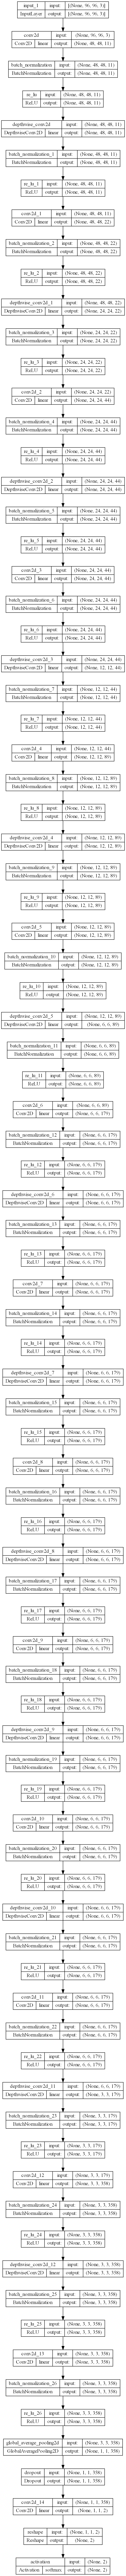

In [45]:
tf.keras.utils.plot_model(
    model,
    to_file=models_image_path,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",  # TB for vertical plot, LR for horizontal plot
    expand_nested=True,
    layer_range=None,
    dpi=200,
    show_layer_activations=True,
)

# Save the model summary


In [46]:
mltk_summary = summarize_model(model)
print(mltk_summary)


Model: "mobilenetv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 11)        308       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 11)       44        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 48, 48, 11)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 48, 48, 11)       110       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 11)       

In [47]:
# save the model summary to disk

from contextlib import redirect_stdout

with open(models_summary_path, "w", encoding='utf-8') as f:
    with redirect_stdout(f):
        print(mltk_summary)

In [48]:
#model.build(input_shape)

In [49]:
# MLTK profile model reads the mode from a path - only works for MLTK models! / Model must be trained first?
# This only works with TFLite Models!

#profiling_results = profile_model(model, accelerator='None', build=False)

In [50]:
# total_params, trainable_params, non_trainable_params, MACs, FLOPs = parse_mltk_model_summary(models_summary_path)        

In [51]:
# print(f"MACs: {MACs} - FLOPs {FLOPs}")


In [52]:
# model_stats["MACs"] = MACs
# model_stats["FLOPs"] = FLOPs
# model_stats["total_params"] = total_params
# model_stats["trainable_params"] = trainable_params
# model_stats["non_trainable_params"] = non_trainable_params

# Save the model

In [53]:
model.save(models_tf_path)
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv1_0.35_96_c3_o2_l5/mobilenetv1_0.35_96_c3_o2_l5.h5')

# Linux playground

In [54]:
#! wsl ls ./models

In [55]:
# ! wsl pwd

In [56]:
# ! wsl ls ./models -l >model.txt

In [57]:
#! wsl ls ./models -laR 

In [58]:
#linux_path = models_tflite_path.as_posix()

In [59]:
models_tf_path

WindowsPath('i:/tinyml/tiny_cnn/models/mobilenetv1_0.35_96_c3_o2_l5/mobilenetv1_0.35_96_c3_o2_l5.h5')

In [60]:
if automated == False:

    ! explorer $models_path

In [65]:
with open("analyzer_list.txt", "a") as f:
    f.write(f"{model_name}\n")